In [1]:
#import os
#os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [2]:
import os
import cv2 as cv
import numpy as np

from mtcnn import MTCNN
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.applications import Xception 
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import ResNet152V2

In [3]:
import tensorflow as tf
from tensorflow.keras import applications

# List all attributes in the keras applications module
available_models = dir(applications)

# Print available models
print("Available models in keras.applications:")
for model in available_models:
    print(model)

Available models in keras.applications:
DenseNet121
DenseNet169
DenseNet201
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5
EfficientNetB6
EfficientNetB7
InceptionResNetV2
InceptionV3
MobileNet
MobileNetV2
MobileNetV3Large
MobileNetV3Small
NASNetLarge
NASNetMobile
ResNet101
ResNet101V2
ResNet152
ResNet152V2
ResNet50
ResNet50V2
VGG16
VGG19
Xception
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
_sys
densenet
efficientnet
imagenet_utils
inception_resnet_v2
inception_v3
mobilenet
mobilenet_v2
mobilenet_v3
nasnet
resnet
resnet50
resnet_v2
vgg16
vgg19
xception


In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device name: {details['device_name']}")
else:
    print("No GPU devices found")

Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
class FACELOADING:
    def __init__(self, video_list, frame_interval, save_dir, max_frames_per_video=None):
        """
        Initialize the face loader.

        Args:
            video_list: List of video paths.
            frame_interval: The interval (in seconds) at which frames are saved (e.g., 1 means save every 1 second).
            save_dir: Directory to save the extracted frames.
            max_frames_per_video: The maximum number of frames to extract from each video. If None, no limit.
        """
        self.video_list = video_list  
        self.save_dir = save_dir
        self.frame_interval = frame_interval  
        self.max_frames_per_video = max_frames_per_video  
        self.target_size = (299, 299)  
        os.makedirs(self.save_dir, exist_ok=True)  
        self.detector = MTCNN() 

    def extract_face(self, img):
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  
        faces = self.detector.detect_faces(img_rgb)

        for face in faces:
            if face['confidence'] > 0.90:
                x, y, w, h = face['box']
                x, y = abs(x), abs(y)  
                
                face_img = img_rgb[y:y+h, x:x+w]
                face_arr = cv.resize(face_img, self.target_size)  

                return face_arr

        return None

    def load_faces(self, video_path):
        cap = cv.VideoCapture(video_path)
        fps = cap.get(cv.CAP_PROP_FPS)  
        frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) 

        video_name = os.path.splitext(os.path.basename(video_path))[0]  
        
        frame_interval_in_frames = int(fps * self.frame_interval)

        max_frames = self.max_frames_per_video if self.max_frames_per_video else frame_count

        frame_idx = frame_interval_in_frames  
        frames_saved = 0

        while frame_idx < frame_count and frames_saved < max_frames:
            cap.set(cv.CAP_PROP_POS_FRAMES, frame_idx) 
            ret, frame = cap.read()
            if ret:
                face = self.extract_face(frame)
                if face is not None:
                    face_filename = f"{video_name}_frame{frame_idx}.png"
                    face_path = os.path.join(self.save_dir, face_filename)
                    cv.imwrite(face_path, cv.cvtColor(face, cv.COLOR_RGB2BGR))  
                    frames_saved += 1

            frame_idx += frame_interval_in_frames

        cap.release()

    def load_classes(self):
        saved_faces_paths = []

        for video_path in self.video_list:
            self.load_faces(video_path)
            
            video_name = os.path.splitext(os.path.basename(video_path))[0]
            frame_files = [f"{video_name}_frame{frame_idx}.png" 
                           for frame_idx in range(self.frame_interval, 
                                                  int(cv.VideoCapture(video_path).get(cv.CAP_PROP_FRAME_COUNT)),
                                                  int(cv.VideoCapture(video_path).get(cv.CAP_PROP_FPS) * self.frame_interval))]
            frame_paths = [os.path.join(self.save_dir, frame_file) for frame_file in frame_files]
            saved_faces_paths.extend(frame_paths)
            print(f"Saved faces from {video_path}")

        return saved_faces_paths

In [5]:
real_videos1_dir = 'Data/Real/c23/videos'
real_videos2_dir = 'Data/youtube/c23/videos'
fake_videos_dir = 'Data/Fake/c23/videos'

In [6]:
real_videos1 = [os.path.join(real_videos1_dir, f) for f in os.listdir(real_videos1_dir) if f.endswith(('.mp4', '.avi', '.mkv'))]
real_videos2 = [os.path.join(real_videos2_dir, f) for f in os.listdir(real_videos2_dir) if f.endswith(('.mp4', '.avi', '.mkv'))]
fake_videos = [os.path.join(fake_videos_dir, f) for f in os.listdir(fake_videos_dir) if f.endswith(('.mp4', '.avi', '.mkv'))]

real_videos = real_videos1 + real_videos2

In [6]:
output1 = 'Data/ViT/Real'
output2 = 'Data/ViT/Fake'

In [10]:
#real_face_loader = FACELOADING(real_videos, frame_interval=1, max_frames_per_video=1, save_dir=output1)  
#saved_face_paths = real_face_loader.load_classes()


In [11]:
#fake_face_loader = FACELOADING(fake_videos, frame_interval=1, max_frames_per_video=1, save_dir=output2)
#saved_face_paths = fake_face_loader.load_classes()

In [8]:
def load_images_from_directory(directory, resize=False, size=None, max_images=None):
    """
    Load all images from a specified directory, with optional resizing, and limit the number of images.

    Args:
        directory (str): Path to the directory containing images.
        resize (bool): Whether to resize images. Default is False.
        size (tuple): Size to resize images to if resize is True. Default is (128, 128).
        max_images (int): Maximum number of images to load. Default is 10000.

    Returns:
        list: List of images loaded as NumPy arrays.
    """
    images = []
    last_image_name = None  
    
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  
            img_path = os.path.join(directory, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                
                if resize:
                    img = cv.resize(img, size)
                
                img = (img / 255.0).astype(np.float32)
                images.append(img)
                last_image_name = filename  
                
                if len(images) >= max_images:
                    break
            else:
                print(f"Warning: {img_path} could not be read.")
    
    if last_image_name:
        print(f"Last image loaded: {last_image_name}")
    
    return images

In [9]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()

# Xception

In [8]:
real_faces = load_images_from_directory(output1, resize=False, size=None, max_images=10000)

Last image loaded: 640_frame90.png


In [9]:
fake_faces = load_images_from_directory(output2, resize=False, size=None, max_images=10000)

Last image loaded: 18_03__exit_phone_room__N72YE748_frame96.png


In [10]:
real_labels = np.zeros(len(real_faces), dtype=int) 
fake_labels = np.ones(len(fake_faces), dtype=int)

In [11]:
X = np.concatenate((real_faces, fake_faces), axis=0)
Y = np.concatenate((real_labels, fake_labels), axis=0)

In [12]:
real_faces = None
fake_faces = None

In [13]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

In [14]:
print('Train Data: ', X_train.shape)
print('Validation Data: ', X_val.shape)
print('Test Data: ', X_test.shape)

Train Data:  (14000, 299, 299, 3)
Validation Data:  (2000, 299, 299, 3)
Test Data:  (4000, 299, 299, 3)


In [15]:
class_names = ['0', '1']
class_count = len(class_names)
class_count

2

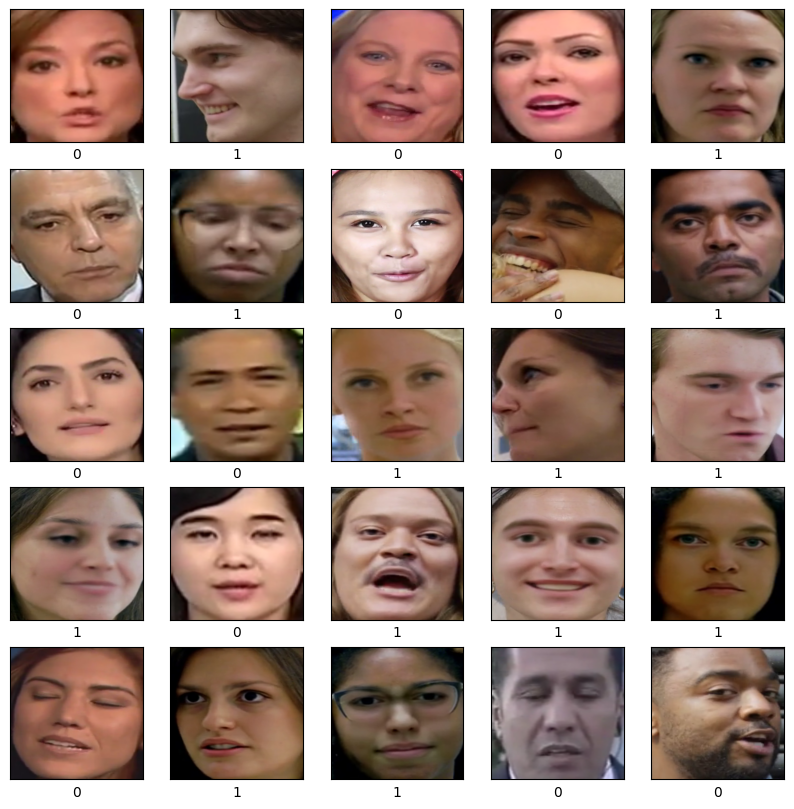

In [16]:
show_example(X_train, Y_train, class_names)

In [41]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    fill_mode='nearest'
)

X_train_aug = np.array([datagen.random_transform(x) for x in X_train])

In [55]:
batch_size = 32

# Data generators
def data_generator(X, Y):
    for x, y in zip(X, Y):
        yield x, y

# Train dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, Y_train),
    output_signature=(tf.TensorSpec(shape=X_train.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val, Y_val),
    output_signature=(tf.TensorSpec(shape=X_val.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, Y_test),
    output_signature=(tf.TensorSpec(shape=X_test.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [56]:
base_model = Xception(
    weights='imagenet', 
    input_shape=(299, 299, 3),
    include_top=False) 

In [57]:
base_model.trainable = True 

for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

In [58]:
inputs = keras.Input(shape=(299, 299, 3), dtype=tf.uint8)
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [59]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [60]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.Xception.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/30
438/438 [==============================] - 236s 373ms/step - loss: 0.6869 - binary_accuracy: 0.5278 - val_loss: 0.6661 - val_binary_accuracy: 0.4945
Epoch 2/30
438/438 [==============================] - 214s 454ms/step - loss: 0.6711 - binary_accuracy: 0.5451 - val_loss: 0.6630 - val_binary_accuracy: 0.6020
Epoch 3/30
438/438 [==============================] - 206s 453ms/step - loss: 0.6624 - binary_accuracy: 0.5526 - val_loss: 0.6462 - val_binary_accuracy: 0.5915
Epoch 4/30
438/438 [==============================] - 205s 457ms/step - loss: 0.6594 - binary_accuracy: 0.5607 - val_loss: 0.6435 - val_binary_accuracy: 0.5975
Epoch 5/30
438/438 [==============================] - 209s 465ms/step - loss: 0.6574 - binary_accuracy: 0.5655 - val_loss: 0.6419 - val_binary_accuracy: 0.5925
Epoch 6/30
438/438 [==============================] - 207s 460ms/step - loss: 0.6560 - binary_accuracy: 0.5688 - val_loss: 0.6441 - val_binary_accuracy: 0.5915
Epoch 7/30
438/438 [====================

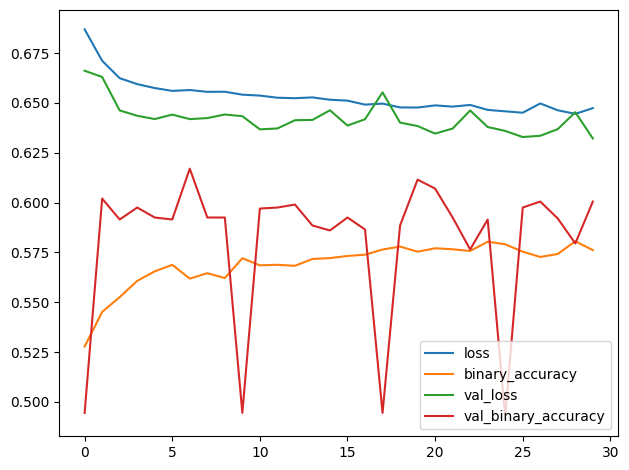

In [61]:
history=model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=model_checkpoint_callback)
show_history(history)

In [62]:
model.load_weights("weights.best.Xception.hdf5")
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: ', test_acc)

125/125 [==============================] - 25s 193ms/step - loss: 0.6387 - binary_accuracy: 0.5895
Test accuracy:  0.5895000100135803


# EfficientNetB3

In [10]:
real_faces = load_images_from_directory(output1, resize=True, size=(300, 300), max_images=10000)

Last image loaded: 640_frame90.png


In [11]:
fake_faces = load_images_from_directory(output2, resize=True, size=(300, 300), max_images=10000)

Last image loaded: 18_03__exit_phone_room__N72YE748_frame96.png


In [12]:
real_labels = np.zeros(len(real_faces), dtype=int) 
fake_labels = np.ones(len(fake_faces), dtype=int)

In [13]:
X = np.concatenate((real_faces, fake_faces), axis=0)
Y = np.concatenate((real_labels, fake_labels), axis=0)

In [14]:
real_faces = None
fake_faces = None

In [15]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

In [16]:
print('Train Data: ', X_train.shape)
print('Validation Data: ', X_val.shape)
print('Test Data: ', X_test.shape)

Train Data:  (14000, 300, 300, 3)
Validation Data:  (2000, 300, 300, 3)
Test Data:  (4000, 300, 300, 3)


In [89]:
batch_size = 32

# Data generators
def data_generator(X, Y):
    for x, y in zip(X, Y):
        yield x, y

# Train dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, Y_train),
    output_signature=(tf.TensorSpec(shape=X_train.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val, Y_val),
    output_signature=(tf.TensorSpec(shape=X_val.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, Y_test),
    output_signature=(tf.TensorSpec(shape=X_test.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [90]:
base_model = EfficientNetB3(
    weights='imagenet', 
    input_shape=(300, 300, 3),
    include_top=False) 

In [91]:
base_model.trainable = False

In [92]:
inputs = keras.Input(shape=(300, 300, 3), dtype=tf.uint8)
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [93]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [94]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.Efficient.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/30
438/438 [==============================] - 104s 219ms/step - loss: 0.6940 - binary_accuracy: 0.4994 - val_loss: 0.6933 - val_binary_accuracy: 0.4945
Epoch 2/30
438/438 [==============================] - 107s 241ms/step - loss: 0.6932 - binary_accuracy: 0.4967 - val_loss: 0.6932 - val_binary_accuracy: 0.4920
Epoch 3/30
438/438 [==============================] - 107s 241ms/step - loss: 0.6932 - binary_accuracy: 0.4957 - val_loss: 0.6932 - val_binary_accuracy: 0.4945
Epoch 4/30
438/438 [==============================] - 107s 242ms/step - loss: 0.6932 - binary_accuracy: 0.4954 - val_loss: 0.6931 - val_binary_accuracy: 0.5055
Epoch 5/30
438/438 [==============================] - 109s 246ms/step - loss: 0.6932 - binary_accuracy: 0.5019 - val_loss: 0.6931 - val_binary_accuracy: 0.5055
Epoch 6/30
438/438 [==============================] - 113s 255ms/step - loss: 0.6932 - binary_accuracy: 0.4894 - val_loss: 0.6931 - val_binary_accuracy: 0.5055
Epoch 7/30
438/438 [====================

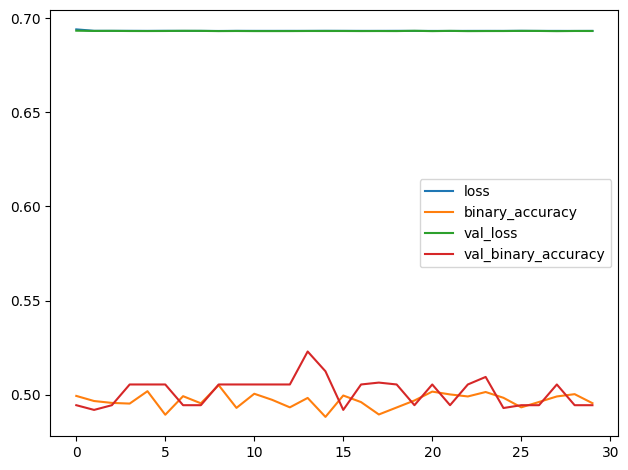

In [95]:
history=model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=model_checkpoint_callback)
show_history(history)

In [96]:
model.load_weights("weights.best.Efficient.hdf5")
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: ', test_acc)

125/125 [==============================] - 27s 211ms/step - loss: 0.6932 - binary_accuracy: 0.4952
Test accuracy:  0.49524998664855957


# ResNet152V2

In [97]:
real_faces = load_images_from_directory(output1, resize=True, size=(224, 224), max_images=10000)

Last image loaded: 640_frame90.png


In [98]:
fake_faces = load_images_from_directory(output2, resize=True, size=(224, 224), max_images=10000)

Last image loaded: 18_03__exit_phone_room__N72YE748_frame96.png


In [99]:
real_labels = np.zeros(len(real_faces), dtype=int) 
fake_labels = np.ones(len(fake_faces), dtype=int)

In [100]:
X = np.concatenate((real_faces, fake_faces), axis=0)
Y = np.concatenate((real_labels, fake_labels), axis=0)

In [101]:
real_faces = None
fake_faces = None

In [102]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

In [103]:
print('Train Data: ', X_train.shape)
print('Validation Data: ', X_val.shape)
print('Test Data: ', X_test.shape)

Train Data:  (14000, 224, 224, 3)
Validation Data:  (2000, 224, 224, 3)
Test Data:  (4000, 224, 224, 3)


In [132]:
batch_size = 16

# Data generators
def data_generator(X, Y):
    for x, y in zip(X, Y):
        yield x, y

# Train dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, Y_train),
    output_signature=(tf.TensorSpec(shape=X_train.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val, Y_val),
    output_signature=(tf.TensorSpec(shape=X_val.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, Y_test),
    output_signature=(tf.TensorSpec(shape=X_test.shape[1:], dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.float32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [133]:
base_model = ResNet152V2(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False) 

In [134]:
base_model.trainable = True 

for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

In [135]:
inputs = keras.Input(shape=(224, 224, 3), dtype=tf.uint8)
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [136]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = keras.metrics.BinaryAccuracy())

In [137]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.ResNet.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/30
875/875 [==============================] - 288s 310ms/step - loss: 0.6529 - binary_accuracy: 0.5762 - val_loss: 0.6304 - val_binary_accuracy: 0.6070
Epoch 2/30
875/875 [==============================] - 316s 360ms/step - loss: 0.6407 - binary_accuracy: 0.5883 - val_loss: 0.6265 - val_binary_accuracy: 0.6100
Epoch 3/30
875/875 [==============================] - 330s 375ms/step - loss: 0.6385 - binary_accuracy: 0.5900 - val_loss: 0.6250 - val_binary_accuracy: 0.6115
Epoch 4/30
875/875 [==============================] - 330s 375ms/step - loss: 0.6333 - binary_accuracy: 0.5956 - val_loss: 0.6227 - val_binary_accuracy: 0.6135
Epoch 5/30
875/875 [==============================] - 332s 378ms/step - loss: 0.6381 - binary_accuracy: 0.5921 - val_loss: 0.6262 - val_binary_accuracy: 0.6110
Epoch 6/30
875/875 [==============================] - 334s 381ms/step - loss: 0.6290 - binary_accuracy: 0.5977 - val_loss: 0.6186 - val_binary_accuracy: 0.6150
Epoch 7/30
875/875 [====================

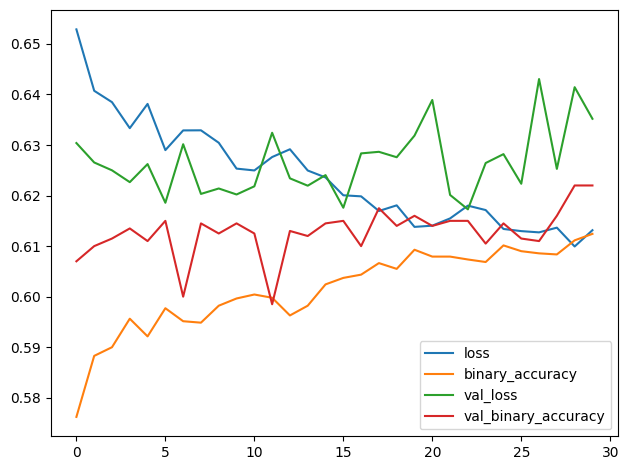

In [138]:
history=model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=model_checkpoint_callback)
show_history(history)

In [139]:
model.load_weights("weights.best.ResNet.hdf5")
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: ', test_acc)

250/250 [==============================] - 33s 134ms/step - loss: 0.6240 - binary_accuracy: 0.6018
Test accuracy:  0.6017500162124634
